# Graded lab session 5 | Deep classification on Fashion-MNIST using pytorch

pierre-henri.conze@imt-atlantique.fr \\
francois.rousseau@imt-atlantique.fr \\
aurelien.colin@imt-atlantique.fr \\
simon.benaichouche@imt-atlantique.fr

---



#### **Student name** = [TO BE COMPLETED] 

### Objective of this lab session: perform classification on Fashion-MNIST using multi-layer perceptron, convolutional neural networks and transfer learning to obtain the best classification results as possible.

#### Challenge: the first 3 students in terms of overall test accuracy results (whatever the methodology used) will obtain bonus points!

### Table of Contents

* [Data management](#section_1)
    * [Question 1.1](#question_1_1)
    * [Question 1.2](#question_1_2)
    * [Question 1.3](#question_1_3)
    * [Question 1.4](#question_1_4)
* [Multi-Layer Perceptron](#section_2)    
    * [Question 2.1](#question_2_1)
    * [Question 2.2](#question_2_2)
    * [Question 2.3](#question_2_3)
    * [Question 2.4](#question_2_4)
    * [Question 2.5](#question_2_5)
* [Convolutional neural network](#section_3)    
    * [Question 3.1](#question_3_1)
    * [Question 3.2](#question_3_2)
    * [Question 3.3](#question_3_3)
    * [Question 3.4](#question_3_4)
    * [Question 3.5](#question_3_5)
    * [Question 3.6](#question_3_6)
    * [Question 3.7](#question_3_7)
* [Transfer learning from ImageNet](#section_4)    
    * [Question 4.1](#question_4_1)
    * [Question 4.2](#question_4_2)
    * [Question 4.3](#question_4_3)
    * [Question 4.4](#question_4_4)
    * [Question 4.5](#question_4_5)
* [Challenge](#section_5)    
    * [Question 5.1](#question_5_1)

## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

26422272it [00:05, 4476672.16it/s]                              


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



29696it [00:00, 960383.46it/s]           


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



4422656it [00:01, 3770819.08it/s]                             


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



6144it [00:00, 3078461.81it/s]          

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw




D:\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### **Question 1.1** - Fashion-MNIST is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D? <a class="anchor" id="question_1_1"></a>

In [22]:
num_train, num_test = len(train_data), len(test_data)
print('A = number of training data =', num_train, '\n'+'B = number of test data =', num_test)
#images, labels = data_iter.next() # obtain one batch from the train set
#images = images.numpy()
num_pixel = len(np.squeeze(images[1]))
num_class = len(train_data.classes)
print('C = number of pixel =', num_pixel, '\n'+'D = number of class =', num_class)


A = number of training data = 60000 
B = number of test data = 10000
C = number of pixel = 28 
D = number of class = 10


As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [2]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#### **Question 1.2** - Complete the following cell to create data loaders ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [8]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED
  # obtain training indices that will be used for validation
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  # prepare data loaders
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
  
  return train_loader, valid_loader, test_loader

In [9]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **Question 1.3** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

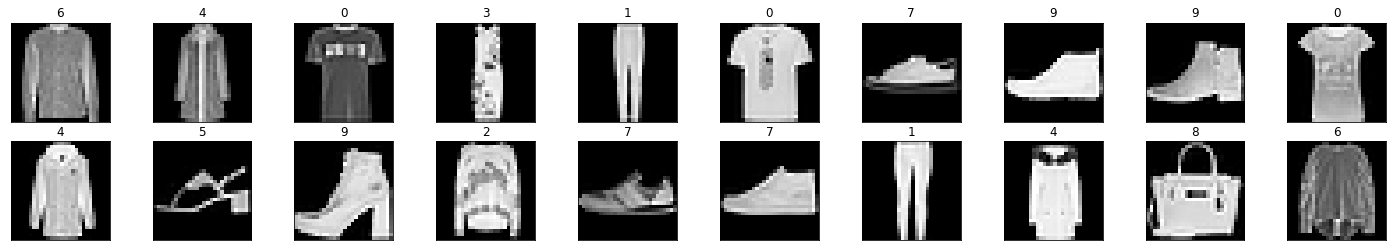

In [10]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader) 
images, labels = data_iter.next() # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor


#### **Question 1.4** - View one of these images with more details by superimposing the greyscale intensity values directly on it. <a class="anchor" id="question_1_4"></a>

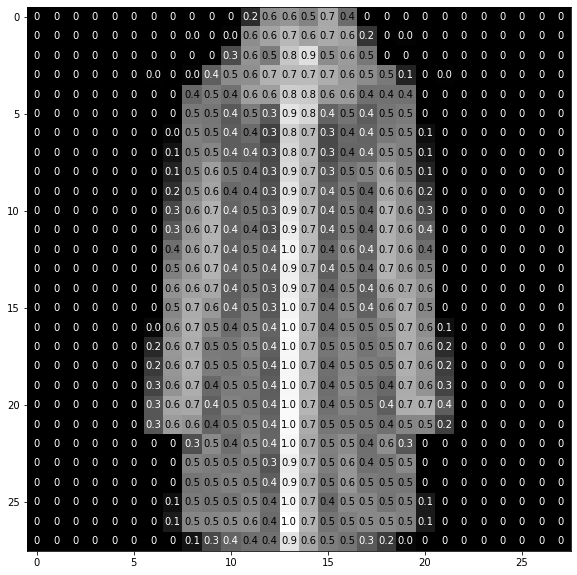

In [11]:
# CELL TO BE COMPLETED
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')


## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **Question 2.1** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module): 
    def __init__(self): # FUNCTION TO BE COMPLETED
        super(MLP,self).__init__()
 



    def forward(self,x): # FUNCTION TO BE COMPLETED

        
        
        
        return x

#### **Question 2.2** - Train the pre-defined MPL network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

In [ ]:
model_1 = MLP()
model_1.to(device=device)

In [ ]:
#DEFINE THE CRITERION
criterion =         # TO DO

In [ ]:
#DEFINE THE OPTIMIZER
optimizer =         # TO DO

In [ ]:
n_epochs = 30

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer): # FUNCTION TO BE COMPLETED

  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0
      
      model.train()
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          #TO BE COMPLETED
          #...  
            
            
            
            
            
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          #TO BE COMPLETED
          #...  

            
            
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [ ]:
#RUN THE TRAINING FUNCTION
train_losses_1, valid_losses_1 = # TO DO

#### **Question 2.3** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

In [ ]:
# CELL TO BE COMPLETED







Let us load the model corresponding to the lowest validation loss.

In [ ]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

#### **Question 2.4** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [ ]:
def evaluation(model, test_loader, criterion): 

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation() # TO DO

#### **Question 2.5** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [ ]:
def get_all_prediction(model, loader): 
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_1 =  # TO DO

In [ ]:
# CELL TO BE COMPLETED







## 3- Convolutional neural network (CNN) <a class="anchor" id="section_3"></a>

Let us now switch from MLP to convolutional neural network (CNN) to classify Fashion-MNIST images.

#### **Question 3.1** - Define a CNN architecture using (at least) 2 patterns [CONV - CONV - POOL] as well as dropout and fully-connected layers. <a class="anchor" id="question_3_1"></a>

In [ ]:
class CNN(nn.Module):

    def __init__(self): # FUNCTION TO BE COMPLETED
        super(CNN,self).__init__()
        

        
        
        
        
        
        
        
    def forward(self,x): # FUNCTION TO BE COMPLETED

        
        
        
        
        
        
        
        
        return out

#### **Question 3.2** - Describe input/output sizes of each layer using summary() from torchsummary. <a class="anchor" id="question_3_2"></a>

In [ ]:
from torchsummary import summary

model_2 = CNN()
model_2.to(device=device)

# CALL THE SUMMARY FUNCTION TO DISPLAY THE ARCHITECTURE


#### **Question 3.3** - Train the pre-defined CNN network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_3_3"></a>

In [ ]:
#DEFINE THE OPTIMIZER
optimizer =         # TO DO

In [ ]:
#RUN THE TRAINING FUNCTION
train_losses_2, valid_losses_2 =  # TO DO

#### **Question 3.4** - Display in a single graph the loss functions for training and validation sets obtained with both MLP and CNN models. <a class="anchor" id="question_3_4"></a>

In [ ]:
# CELL TO BE COMPLETED



As previously, we load the model corresponding to the lowest validation loss.

In [ ]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

#### **Question 3.5** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the ones obtained using MLP. <a class="anchor" id="question_3_5"></a>

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(   ) # TO DO

#### **Question 3.6** - Display CNN results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "CNN label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_3_6"></a>

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_2 =  # TO DO

In [ ]:
# CELL TO BE COMPLETED







#### **Question 3.7** - Display the confusion matrix for both MLP and CNN models. <a class="anchor" id="question_3_7"></a>

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
# CELL TO BE COMPLETED
# compute confusion matrix
cnf_matrix_MLP = 
cnf_matrix_CNN = 
np.set_printoptions(precision=2)

# plot normalized confusion matrixes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_MLP, classes=class_names, normalize=True, title='MLP')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_CNN, classes=class_names, normalize=True, title='CNN')
plt.show()

## 4- Transfer learning from ImageNet <a class="anchor" id="section_4"></a>

Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

Our goal is to use a (well-known) CNN architecture whose weights have been already trained on ImageNet to perform transfer learning and fine tuning. ImageNet is a large visual database designed for visual object recognition purposes wich contains more than 14 million images!

#### **Question 4.1** - Modify the Fashion-MNIST dataset to make it fit to  ImageNet by extending Fashion-MNIST images from greyscale to 3-channels images. Since the minimal image dimension as inputs of pre-trained CNN models is 48x48, you will also need to resize images. To do so, use transform.Compose(), transforms.Resize() and transforms.Grayscale(). More details on image transformations are available in the [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html). <a class="anchor" id="question_4_1"></a>

In [ ]:
#CALL transforms.Compose to adapt the dataset to the VGG16 architecture
transform =  # TO DO

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

#### **Question 4.2** - Create training, validation and test data loaders. Check the dimensions of images arising from the modified Fasion-MNIST dataset. <a class="anchor" id="question_4_2"></a>

In [ ]:
# CELL TO BE COMPLETED
train_loader, valid_loader, test_loader =    #TO DO
data_iter =   #TO DO
images, labels = data_iter.next()
print(images.numpy().shape)

#### **Question 4.3** - Exploit a vgg16 architecture ([related paper](https://arxiv.org/pdf/1409.1556.pdf)) pre-trained on ImageNet to improve the classification scores on Fashion-MNIST through fine-tuning. See the [documentation](https://pytorch.org/docs/stable/torchvision/models.html) for further details. Use summary() from torchsummary to describe each of the vgg16 layers. To avoid a too long learning time, you may use only 5 epochs during fine-tuning. <a class="anchor" id="question_4_3"></a>

In [ ]:
import torchvision.models as models

model_3 =  # TO DO
model_3.to(device=device)
summary(model_3, (3, 48, 48))

In [ ]:
#DEFINE THE OPTIMIZER
optimizer =         # TO DO

In [ ]:
n_epochs = 5
#RUN THE TRAINING FUNCTION
train_losses_3, valid_losses_3 =     # TO DO

#### **Question 4.4** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the previously obtained ones. <a class="anchor" id="question_4_4"></a>

In [ ]:
model_3.load_state_dict(torch.load('model.pt', map_location=device))

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(   ) # TO DO

#### **Question 4.5** - Display results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "vgg16 label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_4_5"></a>

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_3 =    # TO DO

In [ ]:
# CELL TO BE COMPLETED





## 5- Challenge <a class="anchor" id="section_5"></a>

#### **Question 5.1** - What is your best overall test accuracy and with which methodology? The first 3 teams will obtain bonus points! <a class="anchor" id="question_5_1"></a>